## Impute Daily Max Min Temps

This notebook uses MissForests to impute max and min daily temps at Cass basin.

In [1]:
import Database_Utils as utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import sklearn.experimental as skexp
import sklearn.impute as skimp
import sklearn.linear_model as sklrm
import sklearn.metrics as mtrcs
import sys
import sklearn.neighbors._base
from sklearn.experimental import enable_iterative_imputer
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from missingpy import MissForest
import os

database_dir = os.getcwd() # path of All_Data directory 
metadata = pd.read_csv(database_dir+'Metadata.csv',index_col=0)

#### Data Wrangling

Several things are done to make the data nicer to impute. First the data is collected from all stations into a single dataframe. Then some wrangling occurs to make the data nicer to work with. The two arthurs pass stations are combined in a 'pre-imputation.'

In [2]:
# temp_stations = [('Cass','Cleaned'),
#                  ('Chilton', 'Cleaned'),
#                 ('ArthursCombined','Formatted'),
#                 ('CragieburnForestTemps','Formatted'),
#                 ('ArthursTemps','Formatted'),
#                 ('ArthursEWS','Formatted'),
#                 ('BrokenRiverCombined','Formatted'),
#                 ('BrokenRiverTemp','Formatted'),
#                 ('CragieburnForestCombined','Formatted')]
temp_stations = [
                ('Cass','Cleaned'),
                ('Chilton', 'Cleaned'),
                ('ArthursCombined','Formatted'),
                ('CragieburnForestTemps','Formatted'),
                ('ArthursTemps','Formatted'),
                ('ArthursEWS','Formatted'),
                ('CragieburnForestCombined','Formatted'),
                # # ('OtiraTemps','Formatted'),
                ('BrokenRiverCombined','Formatted'),
                ('BrokenRiverTemp','Formatted'),
                ]

temp_params = ['Air_Temp_Max','Air_Temp_Min'] # The Variables to use

# Collect all data into one dataframe
temp_data = utils.collect_variables(temp_stations,temp_params, 1965, 2020, 'Daily',database_dir)

# Drop any empty rows or columns, hopefully there are none of either
temp_data.dropna(axis=0,how='all',inplace=True)
temp_data.dropna(axis=1,how='all',inplace=True)

# Index by datetime
temp_data.index = pd.DatetimeIndex(temp_data.index.date)

# Convert some of the 0900 hours stations to 0000
temp_data = utils.transformTemps_900_to_000(temp_data, 'CragieburnForestTemps')
temp_data = utils.transformTemps_900_to_000(temp_data, 'ArthursTemps')
# temp_data = utils.transformTemps_900_to_000(temp_data, 'OtiraTemps')
temp_data = utils.transformTemps_900_to_000(temp_data, 'BrokenRiverTemp')

# Combine some of the redundant datasets
temp_data = utils.combine_and_drop(temp_data, 'ArthursTemps', 'ArthursCombined')
temp_data = utils.combine_and_drop(temp_data, 'CragieburnForestTemps', 'CragieburnForestCombined')
temp_data = utils.combine_and_drop(temp_data, 'BrokenRiverTemp', 'BrokenRiverCombined')

# Drop any duplicated rows
temp_data=temp_data.loc[~temp_data.index.duplicated(), :]

# Use Arthurs Pass EWS to gap fill a few missing values in ArthursTemps and then drop it from dataset to reduce redundancy 
temp_data = utils.pre_impute(temp_data,[
                            'Air_Temp_Min_ArthursEWS',
                            'Air_Temp_Max_ArthursEWS',
                            'Air_Temp_Min_ArthursTemps', 
                            'Air_Temp_Max_ArthursTemps'],
                            imputer=MissForest(n_estimators=200, max_features = 2, max_iter =20),
                            target='ArthursTemps')

('BrokenRiverTemp', 'Formatted'): 2020                          

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7


### Plot dataset

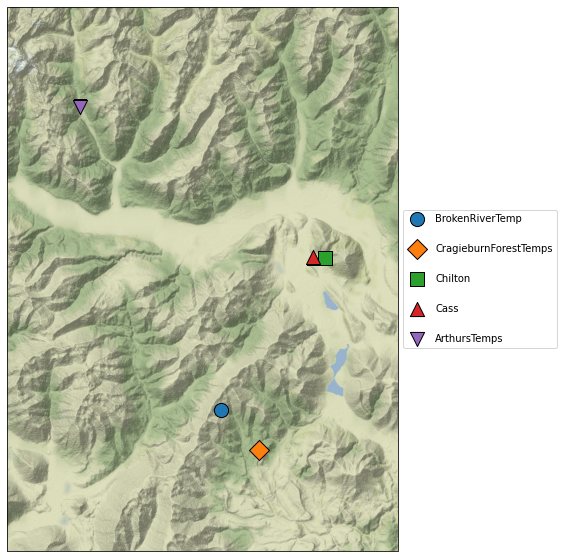

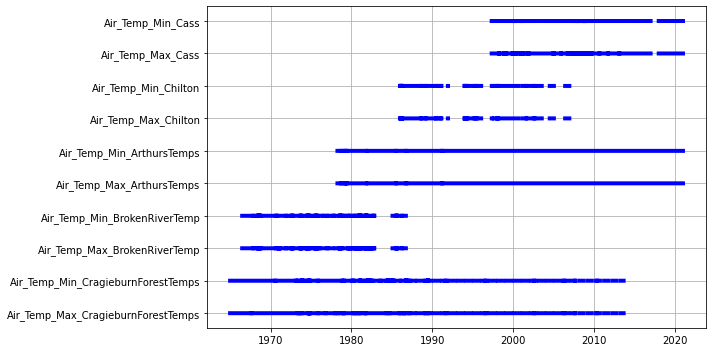

In [139]:
utils.map_stations(temp_data, metadata,map_zoom=12,markersize=200,legend_labelspacing=2,figpath='c:/Users/callu/Pictures/temp_map.png',figsize = (10,10),extent_pad=0.3)
utils.plot_continuity(temp_data, figsize = (10,5),figpath='C:/Users/Callu/Pictures/TempForest_cont.png')

# Impute
This is the impuation phase. There are a couple of different options here, use them by uncommenting/commenting them. 

In [3]:
model = sklrm.LinearRegression()
imputatorRF = MissForest(n_estimators=400,max_iter =30,max_depth=20, max_features = 3,n_jobs=-1)

'''Impute with no testing '''
rf = utils.impute_multiple(temp_data, imputatorRF, 1)
rf.fit_transform(training_data=False)

'''Impute with random samples and 10 imputations and plot evaluation, takes a while'''
# rf.split_tests_trains()
# rf = utils.impute_multiple(temp_data, imputatorRF, 10)
# rf.fit_transform(training_data=True)
# rf.plot_evaluation(figpath=(database_dir+'/Temp_err.png'))

'''Impute with two simulated station blackouts in Cass'''
# blackouts = [[pd.Timestamp(2010,5,1,0,0,0),pd.Timestamp(2010,9,1,0,0,0)],
#              [pd.Timestamp(1999,1,1,0,0,0),pd.Timestamp(1999,5,1,0,0,0)]]
# rf = utils.impute_multiple(temp_data, imputatorRF, 1)
# rf.blackout(holes=blackouts, stations=['Cass'])
# rf.fit_transform(training_data=True)

Imputation 1 of 1 with seed 155510
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21


'Impute with two simulated station blackouts in Cass'

# PLot Blackouts
This is a handy little example of how you can plot the imputed blackout data against the known raw data, only works if you have created a station blackout of course.

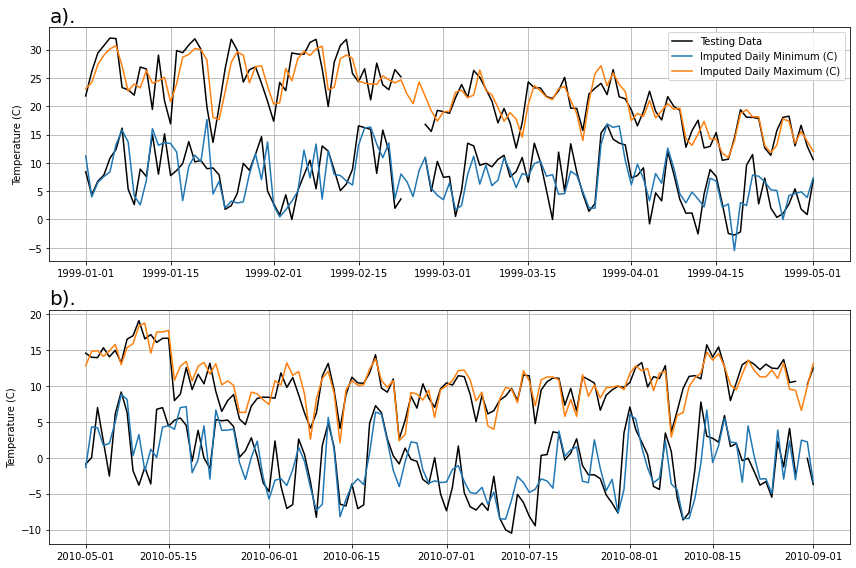

In [9]:
var = ['Air_Temp_Min_Cass','Air_Temp_Max_Cass']

fig, (ax1,ax2) = plt.subplots(2,1,figsize=(12,8))
ax2.plot(temp_data[var].loc[dt.date(2010, 5, 1):dt.date(2010, 9, 1)],c='k')
ax2.plot(rf.datasets[0][var].loc[dt.date(2010, 5, 1):dt.date(2010, 9, 1)])
ax2.set_ylabel('Temperature (C)')
ax2.set_title('b).',loc='left',size=20)
ax1.plot(temp_data[var[0]].loc[dt.date(1999, 1, 1): dt.date(1999, 5, 1)],c='k', label='Testing Data')
ax1.plot(temp_data[var[1]].loc[dt.date(1999, 1, 1): dt.date(1999, 5, 1)],c='k')
ax1.plot(rf.datasets[0][var].loc[dt.date(1999, 1, 1): dt.date(1999, 5, 1)],label=['Imputed Daily Minimum (C)','Imputed Daily Maximum (C)'])
ax1.legend()
ax1.set_title('a).',loc='left',size=20)
ax1.set_ylabel('Temperature (C)')
fig.tight_layout()
ax1.grid()
ax2.grid()

ax2.grid
plt.savefig('C:/Users/callu/Pictures/temp_plt.png',dpi=200)

# Plot annual means
This makes a plot of the annual means and puts it on a nice plot

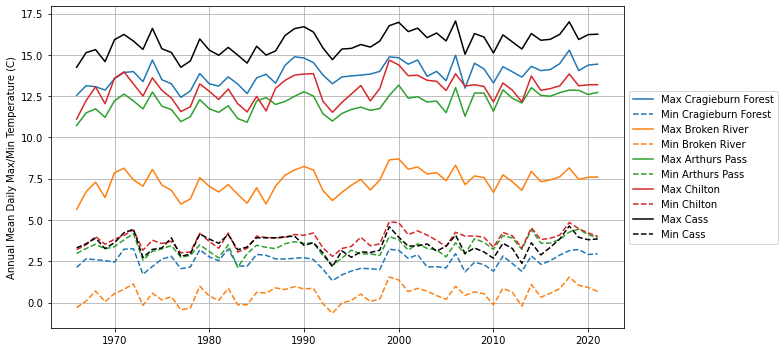

In [4]:
rf.combine_datasets()
yearly_means = rf.datasets[0].loc[dt.date(1965, 1, 1):].groupby(pd.Grouper(freq='1Y')).mean()

plot_dict = {'Air_Temp_Max_CragieburnForestTemps': ['Max Cragieburn Forest', '#1f77b4','-'],
             'Air_Temp_Min_CragieburnForestTemps': ['Min Cragieburn Forest', '#1f77b4','--'],
             'Air_Temp_Max_BrokenRiverTemp': ['Max Broken River', '#ff7f0e','-'],
             'Air_Temp_Min_BrokenRiverTemp': ['Min Broken River', '#ff7f0e','--'],
             'Air_Temp_Max_ArthursTemps': ['Max Arthurs Pass', '#2ca02c','-'],
             'Air_Temp_Min_ArthursTemps': ['Min Arthurs Pass', '#2ca02c','--'],
             'Air_Temp_Max_Chilton': ['Max Chilton', '#d62728','-'],
             'Air_Temp_Min_Chilton': ['Min Chilton', '#d62728','--'],
             'Air_Temp_Max_Cass': ['Max Cass', 'k','-'],
             'Air_Temp_Min_Cass': ['Min Cass', 'k','--']
            }

fig, ax =plt.subplots(1,1,figsize=(11,5))
for c in yearly_means.columns:
    
    ax.plot(yearly_means[c],label=plot_dict[c][0],c=plot_dict[c][1],linestyle=plot_dict[c][2])
#ax.scatter(yearly_means.index,yearly_means.Rain_Cass,label=yearly_means.columns)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_ylabel('Annual Mean Daily Max/Min Temperature (C)')
plt.tight_layout()
ax.grid()
# plt.savefig('C:/Users/callu/Pictures/Temp_time.png',dpi=250)
plt.show()

Here is an example of using OLS to fit a linear regression to the data.

In [144]:
import pandas as pd
import numpy as np
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

data = yearly_means
X = np.arange(len(data))
y = data.Air_Temp_Min_ArthursTemps

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                                OLS Regression Results                               
Dep. Variable:     Air_Temp_Min_ArthursTemps   R-squared:                       0.184
Model:                                   OLS   Adj. R-squared:                  0.169
Method:                        Least Squares   F-statistic:                     12.16
Date:                       Thu, 20 Oct 2022   Prob (F-statistic):           0.000980
Time:                               21:48:45   Log-Likelihood:                -35.406
No. Observations:                         56   AIC:                             74.81
Df Residuals:                             54   BIC:                             78.86
Df Model:                                  1                                         
Covariance Type:                   nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

## Save Imputation

In [8]:
rf.save_imputation(out_path = database_dir+'/Imputations/Temps_1965_2021.csv')